In [1]:
import sys

sys.path.append("C:\\Users\\Gabija\\anaconda3\\Lib\\site-packages")
import nb_black

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import Image
import myfunctions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from csv import QUOTE_NONNUMERIC, QUOTE_NONE

%matplotlib inline
import warnings


from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Audio

sound_file = "button-13.wav"
set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

## Bureau table analysis

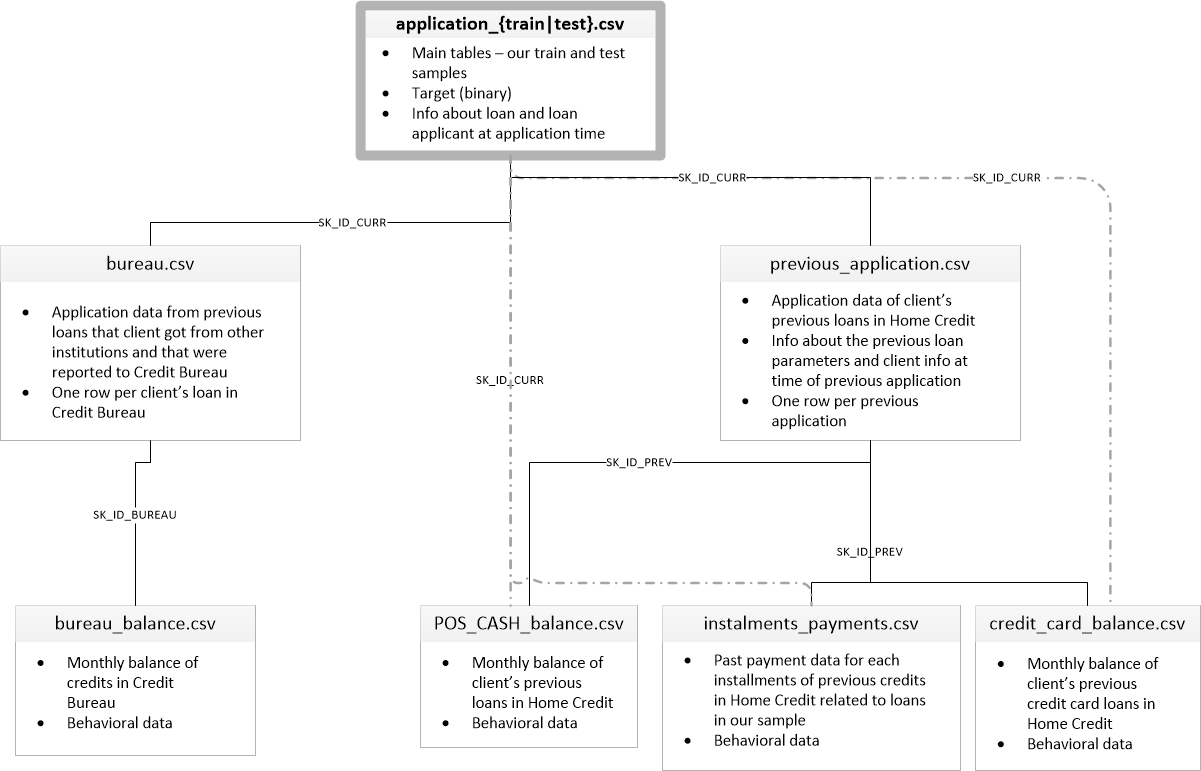

<IPython.core.display.Javascript object>

In [3]:
Image(filename="home_credit.png")

In [4]:
columns_description = pd.read_csv(
    "HomeCredit_columns_description.csv",
    encoding="latin-1",
    usecols=["Table", "Row", "Description"],
)
columns_description.style.set_properties(subset=["Description"], **{"width": "1000px"})

,Table,Row,Description
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car
5,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has
7,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client
8,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan
9,application_{train|test}.csv,AMT_ANNUITY,Loan annuity


<IPython.core.display.Javascript object>

* Checking next bureau_balance table that is connected to bureau table, because it contains monthly balances of previous credits in Credit Bureau and
bureau_balance table has one row for each month of history of every previous credit reported to Credit Bureau:

In [3]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance = myfunctions.reduce_mem_usage(bureau_balance)
print("Size of bureau_balance table", bureau_balance.shape)
bureau_balance.head()

Size of bureau_balance table (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


<IPython.core.display.Javascript object>

In [4]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int32 
 1   MONTHS_BALANCE  int8  
 2   STATUS          object
dtypes: int32(1), int8(1), object(1)
memory usage: 338.5+ MB


<IPython.core.display.Javascript object>

In [5]:
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


<IPython.core.display.Javascript object>

In [6]:
myfunctions.single_value_features(bureau_balance)

[]

<IPython.core.display.Javascript object>

* checking any missing values:

In [7]:
myfunctions.missing_values_summary(bureau_balance)

There are 0 columns that have missing values.


,Missing Values,% of Total Values,type


<IPython.core.display.Javascript object>

* STATUS: "Status of Credit Bureau loan during the month (active, closed, DPD0-30,...

* C means closed,
* X means status unknown,
* 0 means no Days Past Due or DPD,
* 1 means maximal did during month between 1-30,
* 2 means DPD 31-60,
* … 5 means DPD 120+ or sold or written off)",

In [8]:
bureau_balance["STATUS"].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
bureau_balance[bureau_balance["STATUS"] == "1"].head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
464,5715793,-39,1
465,5715793,-40,1
468,5715793,-43,1
499,5715795,-30,1
500,5715795,-31,1


<IPython.core.display.Javascript object>

* Month of balance relative to application date (-1 means the freshest balance date):

In [27]:
# example of one loan:
bureau_balance[bureau_balance["SK_ID_BUREAU"] == 5715448]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


<IPython.core.display.Javascript object>

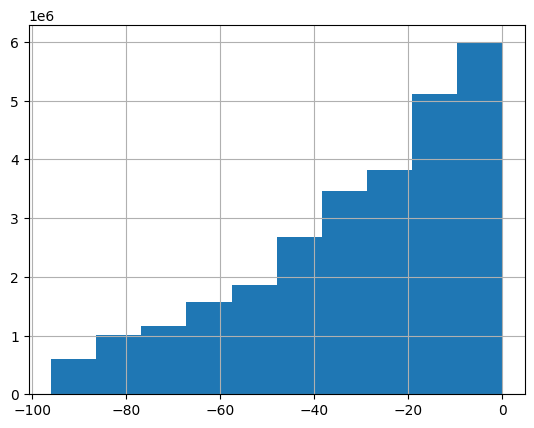

(<Axes: >, None)

<IPython.core.display.Javascript object>

In [28]:
bureau_balance.MONTHS_BALANCE.hist(), plt.show()

#### Create features via OneHotencoder and aggregating additional features:

In [6]:
transformer = ColumnTransformer(
    transformers=[("encode", OneHotEncoder(sparse=False), ["STATUS"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
bureau_balance = transformer.fit_transform(bureau_balance)
bureau_balance = myfunctions.reduce_mem_usage(bureau_balance)

<IPython.core.display.Javascript object>

In [7]:
transformer_agg = FunctionTransformer(myfunctions.aggregate_bureau_balance)
aggregate_balance = Pipeline(steps=[("aggregate_new", transformer_agg)])
bureau_balance = aggregate_balance.fit_transform(bureau_balance)
bureau_balance.head()

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_MEAN_C0_SUM,STATUS_MEAN_12345_SUM
SK_ID_BUREAU,,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0.886598,0.0
5001710,-82,0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0.638554,0.0
5001711,-3,0,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.750000,0.0
5001712,-18,0,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,1.000000,0.0
5001713,-21,0,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0


<IPython.core.display.Javascript object>

* So this is final buro_balace table shape and new features I will add to bureau table fo further investigation:

In [7]:
print(bureau_balance.shape)
bureau_balance.head()

(817395, 13)


,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_MEAN_C0_SUM,STATUS_MEAN_12345_SUM
SK_ID_BUREAU,,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,0.886598,0.0
5001710,-82,0,83,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,0.638554,0.0
5001711,-3,0,4,0.750000,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.750000,0.0
5001712,-18,0,19,0.526316,0.0,0.0,0.0,0.0,0.0,0.473684,0.000000,1.000000,0.0
5001713,-21,0,22,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0


<IPython.core.display.Javascript object>

## Bureau table

In [8]:
bureau = pd.read_csv("bureau.csv")
bureau = myfunctions.reduce_mem_usage(bureau)
print("Size of bureau table", bureau.shape)
bureau.head()

Size of bureau table (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<IPython.core.display.Javascript object>

* All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
* For every loan there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [16]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float16
 7   DAYS_ENDDATE_FACT       float16
 8   AMT_CREDIT_MAX_OVERDUE  float32
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float32
 11  AMT_CREDIT_SUM_DEBT     float32
 12  AMT_CREDIT_SUM_LIMIT    float32
 13  AMT_CREDIT_SUM_OVERDUE  float32
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int32  
 16  AMT_ANNUITY             float32
dtypes: float16(2), float32(6), int16(2), int32(3), int8(1), object(3)
memory usage: 112.9+ MB


<IPython.core.display.Javascript object>

In [17]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1610875.0,1082775.0,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,NaN,NaN,3.825417e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229514e+03,3.791277e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,NaN,NaN,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-42048.0,-42016.0,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1138.0,-1489.0,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-330.0,-897.0,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,474.0,-425.0,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,31200.0,0.0,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


<IPython.core.display.Javascript object>

* ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau, hence duplicated values. I will attend it in the EDA part:

In [18]:
bureau["SK_ID_CURR"].duplicated().sum()

1410617

<IPython.core.display.Javascript object>

In [19]:
myfunctions.single_value_features(bureau)

[]

<IPython.core.display.Javascript object>

* checking any missing values:

In [9]:
myfunctions.missing_values_summary(bureau)

There are 7 columns that have missing values.


,Missing Values,% of Total Values,type
AMT_ANNUITY,1226791,71.4735,float32
AMT_CREDIT_MAX_OVERDUE,1124488,65.5133,float32
DAYS_ENDDATE_FACT,633653,36.9170,float16
AMT_CREDIT_SUM_LIMIT,591780,34.4774,float32
AMT_CREDIT_SUM_DEBT,257669,15.0119,float32
DAYS_CREDIT_ENDDATE,105553,6.1496,float16
AMT_CREDIT_SUM,13,0.0008,float32


<IPython.core.display.Javascript object>

* Check mumber of unique classes in each object column:

In [21]:
bureau.select_dtypes("object").apply(pd.Series.nunique, axis=0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

<IPython.core.display.Javascript object>

* Before merging tables I will reduce credit status (combine 'Sold' and 'Bad debt' as 'Sold_bad_debt') and credit type (combine 'Another type of loan' and 'Unknown type of loan' as 'Another type of loan' also 'Mortgage' and 'Real estate loan' as 'Mortgage' :

In [10]:
transformer_buro = FunctionTransformer(myfunctions.bureau_combine_categories)
combine_categories = Pipeline(steps=[("combine_categ", transformer_buro)])
bureau = combine_categories.fit_transform(bureau)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


<IPython.core.display.Javascript object>

* merging bureau table with bureau_balance table:

In [11]:
bureau = pd.merge(bureau, bureau_balance, how="left", on="SK_ID_BUREAU")
print(bureau.shape)
bureau.head()

(1716428, 30)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_MEAN_C0_SUM,STATUS_MEAN_12345_SUM
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [11]:
myfunctions.missing_values_summary(bureau)

There are 20 columns that have missing values.


,Missing Values,% of Total Values,type
AMT_ANNUITY,1226791,71.4735,float32
AMT_CREDIT_MAX_OVERDUE,1124488,65.5133,float32
STATUS_0_MEAN,942074,54.8857,float32
STATUS_1_MEAN,942074,54.8857,float32
STATUS_MEAN_C0_SUM,942074,54.8857,float32
STATUS_X_MEAN,942074,54.8857,float32
STATUS_C_MEAN,942074,54.8857,float32
STATUS_5_MEAN,942074,54.8857,float32
STATUS_4_MEAN,942074,54.8857,float32
STATUS_3_MEAN,942074,54.8857,float32


<IPython.core.display.Javascript object>

* How many reported loans Home Credit (HC) clients have in Credit Bureau (CB)?

Smallest number of loans per client in CB:  1
Largest number of loans per client in CB:  116


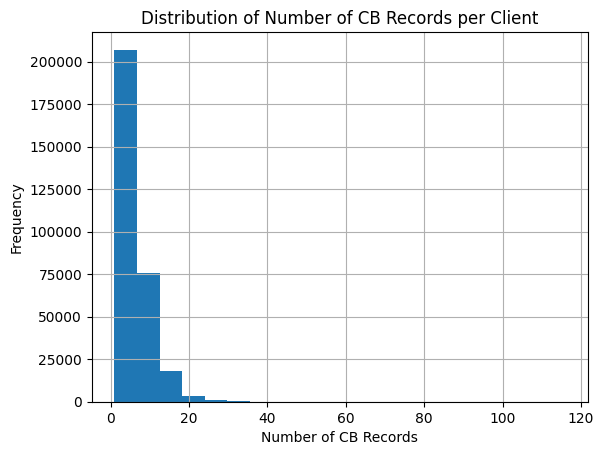

<IPython.core.display.Javascript object>

In [12]:
print(
    "Smallest number of loans per client in CB: ",
    bureau.groupby("SK_ID_CURR")["SK_ID_BUREAU"].count().min(),
)
print(
    "Largest number of loans per client in CB: ",
    bureau.groupby("SK_ID_CURR")["SK_ID_BUREAU"].count().max(),
)
bureau.groupby("SK_ID_CURR")["SK_ID_BUREAU"].count().hist(bins=20)
plt.title("Distribution of Number of CB Records per Client")
plt.xlabel("Number of CB Records")
plt.ylabel("Frequency")
plt.show()

#### Create features via OneHotencoder and aggregating additional features:

In [12]:
transformer = ColumnTransformer(
    transformers=[
        (
            "encode",
            OneHotEncoder(sparse=False),
            ["CREDIT_ACTIVE", "CREDIT_CURRENCY", "CREDIT_TYPE"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
bureau = transformer.fit_transform(bureau)
bureau = myfunctions.reduce_mem_usage(bureau)

<IPython.core.display.Javascript object>

In [13]:
transform_bureau_active = FunctionTransformer(myfunctions.bureau_active_features)
aggregate_bureau_active = Pipeline(steps=[("aggregate_new", transform_bureau_active)])
bureau_agg = aggregate_bureau_active.fit_transform(bureau)
print(bureau_agg.shape)
bureau_agg.head()

(251815, 167)


,index,SK_ID_CURR,CB_ACTIVE_CREDIT_ACTIVE_Active_SUM,CB_ACTIVE_CREDIT_CURRENCY_currency 1_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 2_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 3_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 4_MEAN,CB_ACTIVE_CREDIT_TYPE_Another type of loan_SUM,CB_ACTIVE_CREDIT_TYPE_Car loan_SUM,CB_ACTIVE_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,CB_ACTIVE_CREDIT_TYPE_Consumer credit_SUM,CB_ACTIVE_CREDIT_TYPE_Credit card_SUM,CB_ACTIVE_CREDIT_TYPE_Interbank credit_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for business development_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for the purchase of equipment_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for working capital replenishment_SUM,CB_ACTIVE_CREDIT_TYPE_Microloan_SUM,CB_ACTIVE_CREDIT_TYPE_Mobile operator loan_SUM,CB_ACTIVE_CREDIT_TYPE_Mortgage_SUM,CB_ACTIVE_DAYS_CREDIT_MIN,CB_ACTIVE_DAYS_CREDIT_MAX,CB_ACTIVE_CREDIT_DAY_OVERDUE_SUM,CB_ACTIVE_CREDIT_DAY_OVERDUE_MEAN,CB_ACTIVE_CREDIT_DAY_OVERDUE_MAX,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CB_ACTIVE_DAYS_ENDDATE_FACT_MAX,CB_ACTIVE_DAYS_ENDDATE_FACT_MIN,CB_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,CB_ACTIVE_CNT_CREDIT_PROLONG_SUM,CB_ACTIVE_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_OVERDUE_SUM,CB_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MAX,CB_ACTIVE_DAYS_CREDIT_UPDATE_MIN,CB_ACTIVE_AMT_ANNUITY_SUM,CB_ACTIVE_AMT_ANNUITY_MEAN,CB_ACTIVE_MONTHS_BALANCE_MIN_SUM,CB_ACTIVE_MONTHS_BALANCE_MAX_SUM,CB_ACTIVE_MONTHS_BALANCE_SIZE_SUM,CB_ACTIVE_STATUS_0_MEAN_MEAN,CB_ACTIVE_STATUS_1_MEAN_MEAN,CB_ACTIVE_STATUS_2_MEAN_MEAN,CB_ACTIVE_STATUS_3_MEAN_MEAN,CB_ACTIVE_STATUS_4_MEAN_MEAN,CB_ACTIVE_STATUS_5_MEAN_MEAN,CB_ACTIVE_STATUS_C_MEAN_MEAN,CB_ACTIVE_STATUS_X_MEAN_MEAN,CB_ACTIVE_STATUS_MEAN_C0_SUM_MEAN,CB_ACTIVE_STATUS_MEAN_12345_SUM_MEAN,CB_CLOSED_CREDIT_ACTIVE_Closed_SUM,CB_CLOSED_CREDIT_CURRENCY_currency 1_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 2_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 3_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 4_MEAN,CB_CLOSED_CREDIT_TYPE_Another type of loan_SUM,CB_CLOSED_CREDIT_TYPE_Car loan_SUM,CB_CLOSED_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,CB_CLOSED_CREDIT_TYPE_Consumer credit_SUM,CB_CLOSED_CREDIT_TYPE_Credit card_SUM,CB_CLOSED_CREDIT_TYPE_Interbank credit_SUM,CB_CLOSED_CREDIT_TYPE_Loan for business development_SUM,CB_CLOSED_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,CB_CLOSED_CREDIT_TYPE_Loan for the purchase of equipment_SUM,CB_CLOSED_CREDIT_TYPE_Loan for working capital replenishment_SUM,CB_CLOSED_CREDIT_TYPE_Microloan_SUM,CB_CLOSED_CREDIT_TYPE_Mobile operator loan_SUM,CB_CLOSED_CREDIT_TYPE_Mortgage_SUM,CB_CLOSED_DAYS_CREDIT_MIN,CB_CLOSED_DAYS_CREDIT_MAX,CB_CLOSED_CREDIT_DAY_OVERDUE_SUM,CB_CLOSED_CREDIT_DAY_OVERDUE_MEAN,CB_CLOSED_CREDIT_DAY_OVERDUE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MIN,CB_CLOSED_DAYS_ENDDATE_FACT_MAX,CB_CLOSED_DAYS_ENDDATE_FACT_MIN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CB_CLOSED_CNT_CREDIT_PROLONG_SUM,CB_CLOSED_AMT_CREDIT_SUM_MEAN,CB_CLOSED_AMT_CREDIT_SUM_SUM,CB_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CB_CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CB_CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CB_CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CB_CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CB_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CB_CLOSED_DAYS_CREDIT_UPDATE_MAX,CB_CLOSED_DAYS_CREDIT_UPDATE_MIN,CB_CLOSED_AMT_ANNUITY_SUM,CB_CLOSED_AMT_ANNUITY_MEAN,CB_CLOSED_MONTHS_BALANCE_MIN_SUM,CB_CLOSED_MONTHS_BALANCE_MAX_SUM,CB_CLOSED_MONTHS_BALANCE_SIZE_SUM,CB_CLOSED_STATUS_0_MEAN_MEAN,CB_CLOSED_STATUS_1_MEAN_MEAN,CB_CLOSED_STATUS_2_MEAN_MEAN,CB_CLOSED_STATUS_3_MEAN_MEAN,CB_CLOSED_STATUS_4_MEAN_MEAN,CB_CLOSED_STATUS_5_MEAN_MEAN,CB_CLOSED_STATUS_C_MEAN_MEAN,CB_CLOSED_STATUS_X_MEAN_MEAN,CB_CLOSED_STATU

<IPython.core.display.Javascript object>

In [14]:
# getting "TARGET" column from application_train table:
application_train = pd.read_csv("application_train.csv")
application_train = myfunctions.reduce_mem_usage(application_train)

<IPython.core.display.Javascript object>

In [16]:
bureau_target = pd.merge(
    bureau_agg,
    application_train[["SK_ID_CURR", "TARGET"]],
    how="left",
    on="SK_ID_CURR",
).drop(columns=["index"])

<IPython.core.display.Javascript object>

In [17]:
bureau_target.head()

,SK_ID_CURR,CB_ACTIVE_CREDIT_ACTIVE_Active_SUM,CB_ACTIVE_CREDIT_CURRENCY_currency 1_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 2_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 3_MEAN,CB_ACTIVE_CREDIT_CURRENCY_currency 4_MEAN,CB_ACTIVE_CREDIT_TYPE_Another type of loan_SUM,CB_ACTIVE_CREDIT_TYPE_Car loan_SUM,CB_ACTIVE_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,CB_ACTIVE_CREDIT_TYPE_Consumer credit_SUM,CB_ACTIVE_CREDIT_TYPE_Credit card_SUM,CB_ACTIVE_CREDIT_TYPE_Interbank credit_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for business development_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for the purchase of equipment_SUM,CB_ACTIVE_CREDIT_TYPE_Loan for working capital replenishment_SUM,CB_ACTIVE_CREDIT_TYPE_Microloan_SUM,CB_ACTIVE_CREDIT_TYPE_Mobile operator loan_SUM,CB_ACTIVE_CREDIT_TYPE_Mortgage_SUM,CB_ACTIVE_DAYS_CREDIT_MIN,CB_ACTIVE_DAYS_CREDIT_MAX,CB_ACTIVE_CREDIT_DAY_OVERDUE_SUM,CB_ACTIVE_CREDIT_DAY_OVERDUE_MEAN,CB_ACTIVE_CREDIT_DAY_OVERDUE_MAX,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CB_ACTIVE_DAYS_ENDDATE_FACT_MAX,CB_ACTIVE_DAYS_ENDDATE_FACT_MIN,CB_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,CB_ACTIVE_CNT_CREDIT_PROLONG_SUM,CB_ACTIVE_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,CB_ACTIVE_AMT_CREDIT_SUM_OVERDUE_SUM,CB_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MAX,CB_ACTIVE_DAYS_CREDIT_UPDATE_MIN,CB_ACTIVE_AMT_ANNUITY_SUM,CB_ACTIVE_AMT_ANNUITY_MEAN,CB_ACTIVE_MONTHS_BALANCE_MIN_SUM,CB_ACTIVE_MONTHS_BALANCE_MAX_SUM,CB_ACTIVE_MONTHS_BALANCE_SIZE_SUM,CB_ACTIVE_STATUS_0_MEAN_MEAN,CB_ACTIVE_STATUS_1_MEAN_MEAN,CB_ACTIVE_STATUS_2_MEAN_MEAN,CB_ACTIVE_STATUS_3_MEAN_MEAN,CB_ACTIVE_STATUS_4_MEAN_MEAN,CB_ACTIVE_STATUS_5_MEAN_MEAN,CB_ACTIVE_STATUS_C_MEAN_MEAN,CB_ACTIVE_STATUS_X_MEAN_MEAN,CB_ACTIVE_STATUS_MEAN_C0_SUM_MEAN,CB_ACTIVE_STATUS_MEAN_12345_SUM_MEAN,CB_CLOSED_CREDIT_ACTIVE_Closed_SUM,CB_CLOSED_CREDIT_CURRENCY_currency 1_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 2_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 3_MEAN,CB_CLOSED_CREDIT_CURRENCY_currency 4_MEAN,CB_CLOSED_CREDIT_TYPE_Another type of loan_SUM,CB_CLOSED_CREDIT_TYPE_Car loan_SUM,CB_CLOSED_CREDIT_TYPE_Cash loan (non-earmarked)_SUM,CB_CLOSED_CREDIT_TYPE_Consumer credit_SUM,CB_CLOSED_CREDIT_TYPE_Credit card_SUM,CB_CLOSED_CREDIT_TYPE_Interbank credit_SUM,CB_CLOSED_CREDIT_TYPE_Loan for business development_SUM,CB_CLOSED_CREDIT_TYPE_Loan for purchase of shares (margin lending)_SUM,CB_CLOSED_CREDIT_TYPE_Loan for the purchase of equipment_SUM,CB_CLOSED_CREDIT_TYPE_Loan for working capital replenishment_SUM,CB_CLOSED_CREDIT_TYPE_Microloan_SUM,CB_CLOSED_CREDIT_TYPE_Mobile operator loan_SUM,CB_CLOSED_CREDIT_TYPE_Mortgage_SUM,CB_CLOSED_DAYS_CREDIT_MIN,CB_CLOSED_DAYS_CREDIT_MAX,CB_CLOSED_CREDIT_DAY_OVERDUE_SUM,CB_CLOSED_CREDIT_DAY_OVERDUE_MEAN,CB_CLOSED_CREDIT_DAY_OVERDUE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MIN,CB_CLOSED_DAYS_ENDDATE_FACT_MAX,CB_CLOSED_DAYS_ENDDATE_FACT_MIN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CB_CLOSED_CNT_CREDIT_PROLONG_SUM,CB_CLOSED_AMT_CREDIT_SUM_MEAN,CB_CLOSED_AMT_CREDIT_SUM_SUM,CB_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CB_CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CB_CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CB_CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CB_CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CB_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CB_CLOSED_DAYS_CREDIT_UPDATE_MAX,CB_CLOSED_DAYS_CREDIT_UPDATE_MIN,CB_CLOSED_AMT_ANNUITY_SUM,CB_CLOSED_AMT_ANNUITY_MEAN,CB_CLOSED_MONTHS_BALANCE_MIN_SUM,CB_CLOSED_MONTHS_BALANCE_MAX_SUM,CB_CLOSED_MONTHS_BALANCE_SIZE_SUM,CB_CLOSED_STATUS_0_MEAN_MEAN,CB_CLOSED_STATUS_1_MEAN_MEAN,CB_CLOSED_STATUS_2_MEAN_MEAN,CB_CLOSED_STATUS_3_MEAN_MEAN,CB_CLOSED_STATUS_4_MEAN_MEAN,CB_CLOSED_STATUS_5_MEAN_MEAN,CB_CLOSED_STATUS_C_MEAN_MEAN,CB_CLOSED_STATUS_X_MEAN_MEAN,CB_CLOSED_STATUS_MEAN

<IPython.core.display.Javascript object>

In [19]:
# filter NaN values from "TARGET" into separate dataframe as bureau_test:
bureau_test = bureau_target[pd.isna(bureau_target['TARGET'])]
bureau_test.to_csv("bureau_test.csv")

# filter dataset with "TARGET" values:
bureau_target = bureau_target[pd.notna(bureau_target['TARGET'])]
bureau_target.to_csv("bureau_target.csv")

<IPython.core.display.Javascript object>

#### Feature Selection:

In [4]:
bureau_target = pd.read_csv("bureau_target.csv")
bureau_target = bureau_target.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
bureau_target = myfunctions.reduce_mem_usage(bureau_target)
bureau_target.drop(columns=["Unnamed0"], axis=1, inplace=True)
bureau_target_copy = bureau_target.copy(deep=True)

<IPython.core.display.Javascript object>

In [5]:
# split to train and test for feature selection:
X = bureau_target.drop(labels=["SK_ID_CURR", "TARGET"], axis=1)
y = bureau_target["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((173720, 165), (43430, 165), (173720,), (43430,))

<IPython.core.display.Javascript object>

In [35]:
# checking missing values in final dataset:
myfunctions.missing_values_summary(X_train)

There are 129 columns that have missing values.


,Missing Values,% of Total Values,type
CB_SOLD_AMT_CREDIT_MAX_OVERDUE_MEAN,172893,99.5239,float32
CB_SOLD_AMT_CREDIT_MAX_OVERDUE_MAX,172893,99.5239,float32
CB_SOLD_AMT_CREDIT_SUM_LIMIT_MEAN,172873,99.5124,float32
CB_SOLD_DAYS_ENDDATE_FACT_MAX,172844,99.4957,float16
CB_SOLD_DAYS_ENDDATE_FACT_MIN,172844,99.4957,float16
CB_SOLD_AMT_ANNUITY_MEAN,172815,99.4790,float32
CB_ACTIVE_DAYS_ENDDATE_FACT_MAX,172513,99.3052,float16
CB_ACTIVE_DAYS_ENDDATE_FACT_MIN,172513,99.3052,float16
CB_SOLD_STATUS_2_MEAN_MEAN,172385,99.2315,float16
CB_SOLD_STATUS_0_MEAN_MEAN,172385,99.2315,float16


<IPython.core.display.Javascript object>

In [6]:
# dropping missing values > 46% threshold and filling missin data with 0:
drop_missing = Pipeline(
    steps=[
        ("change_dtypes", FunctionTransformer(myfunctions.reduce_mem_usage)),
        (
            "drop_most_missing",
            FunctionTransformer(myfunctions.bureau_delete_missing_values),
        ),
    ]
)

drop_missing.fit(X_train)
X_train = drop_missing.transform(X_train)
X_test = drop_missing.transform(X_test)

<IPython.core.display.Javascript object>

[LightGBM] [Info] Number of positive: 14198, number of negative: 159522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10624
[LightGBM] [Info] Number of data points in the train set: 173720, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000



Probability:  [0.50048774 0.52949859 0.64127988 ... 0.66604068 0.47639602 0.42713856]



ROC_AUC score:  0.671675004764986


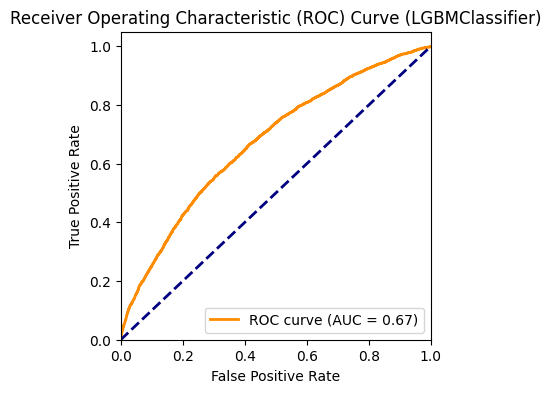

<IPython.core.display.Javascript object>

In [7]:
model = LGBMClassifier(n_jobs=-1, class_weight="balanced", use_missing=False)
final_pipe = Pipeline(steps=[("model", model)])


final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
y_pred_prob = final_pipe.predict_proba(X_test)[:, 1]
print("\n\n\nProbability: ", y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\n\n\nROC_AUC score: ", roc_auc)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve (LGBMClassifier)")
plt.legend(loc="lower right")
plt.show()



<Figure size 800x800 with 0 Axes>

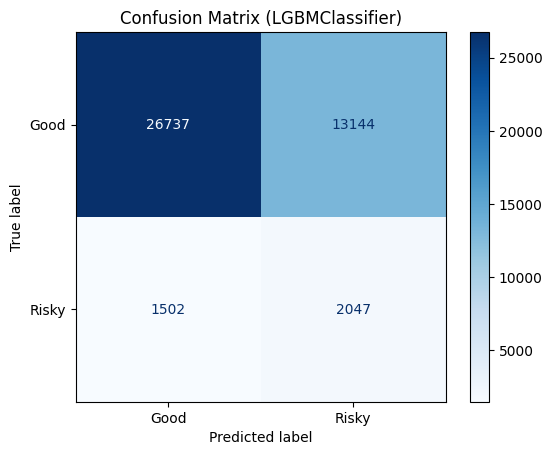

Classification report (LGBMClassifier):
---------------------------
               precision    recall  f1-score   support

        Good       0.95      0.67      0.78     39881
       Risky       0.13      0.58      0.22      3549

    accuracy                           0.66     43430
   macro avg       0.54      0.62      0.50     43430
weighted avg       0.88      0.66      0.74     43430



<IPython.core.display.Javascript object>

In [8]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=["Good", "Risky"])
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_pipe.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.xticks(np.arange(2), ["Good", "Risky"])
plt.yticks(np.arange(2), ["Good", "Risky"])
plt.title("Confusion Matrix (LGBMClassifier)")
plt.show()
print("Classification report (LGBMClassifier):\n---------------------------\n", clr)

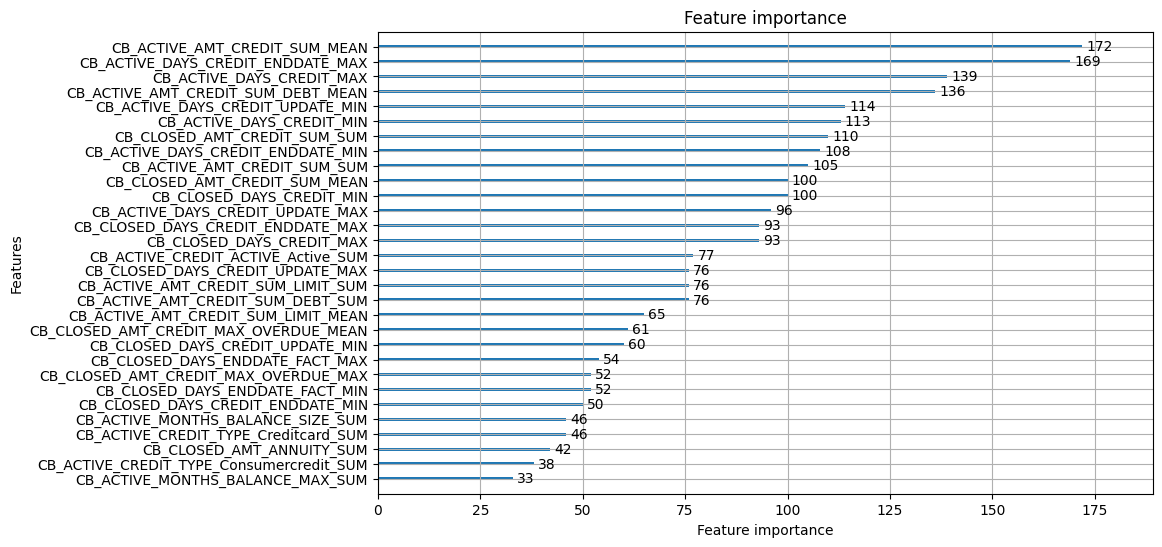

<IPython.core.display.Javascript object>

In [9]:
model_lgb = final_pipe.named_steps["model"]
lgb.plot_importance(model_lgb, figsize=(10, 6), max_num_features=30)
plt.show()

In [10]:
feature_imp = pd.DataFrame(
    sorted(zip(model_lgb.feature_importances_, X_train.columns)),
    columns=["Value", "Feature"],
)
features_df_bureau = feature_imp.sort_values(by="Value", ascending=False)
selected_features_bureau = list(
    features_df_bureau[features_df_bureau["Value"] >= 50]["Feature"]
)
selected_features_bureau

['CB_ACTIVE_AMT_CREDIT_SUM_MEAN',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'CB_ACTIVE_DAYS_CREDIT_MAX',
 'CB_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'CB_ACTIVE_DAYS_CREDIT_UPDATE_MIN',
 'CB_ACTIVE_DAYS_CREDIT_MIN',
 'CB_CLOSED_AMT_CREDIT_SUM_SUM',
 'CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'CB_ACTIVE_AMT_CREDIT_SUM_SUM',
 'CB_CLOSED_DAYS_CREDIT_MIN',
 'CB_CLOSED_AMT_CREDIT_SUM_MEAN',
 'CB_ACTIVE_DAYS_CREDIT_UPDATE_MAX',
 'CB_CLOSED_DAYS_CREDIT_MAX',
 'CB_CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'CB_ACTIVE_CREDIT_ACTIVE_Active_SUM',
 'CB_CLOSED_DAYS_CREDIT_UPDATE_MAX',
 'CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'CB_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CB_CLOSED_DAYS_CREDIT_UPDATE_MIN',
 'CB_CLOSED_DAYS_ENDDATE_FACT_MAX',
 'CB_CLOSED_DAYS_ENDDATE_FACT_MIN',
 'CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX',
 'CB_CLOSED_DAYS_CREDIT_ENDDATE_MIN']

<IPython.core.display.Javascript object>

In [11]:
bureau_selected = bureau_target_copy[
    ["SK_ID_CURR"] + selected_features_bureau
]
bureau_selected.head()

,SK_ID_CURR,CB_ACTIVE_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_DAYS_CREDIT_MAX,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MIN,CB_ACTIVE_DAYS_CREDIT_MIN,CB_CLOSED_AMT_CREDIT_SUM_SUM,CB_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,CB_ACTIVE_AMT_CREDIT_SUM_SUM,CB_CLOSED_DAYS_CREDIT_MIN,CB_CLOSED_AMT_CREDIT_SUM_MEAN,CB_ACTIVE_DAYS_CREDIT_UPDATE_MAX,CB_CLOSED_DAYS_CREDIT_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MAX,CB_ACTIVE_CREDIT_ACTIVE_Active_SUM,CB_CLOSED_DAYS_CREDIT_UPDATE_MAX,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,CB_ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CB_CLOSED_DAYS_CREDIT_UPDATE_MIN,CB_CLOSED_DAYS_ENDDATE_FACT_MAX,CB_CLOSED_DAYS_ENDDATE_FACT_MIN,CB_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CB_CLOSED_DAYS_CREDIT_ENDDATE_MIN
0,100002,240994.28125,780.0,-103,122890.500,-24,-1042,383067.0,780.0,4.819886e+05,-1437.0,63844.500000,-7,-476.0,85.0,2.0,-34.0,31988.564453,245781.0,15994.282227,2091.161133,-1185.0,-36.0,-1185.0,5043.64502,-1072.0
1,100003,810000.00000,1216.0,-606,0.000,-43,-606,207400.5,1216.0,8.100000e+05,-2586.0,69133.500000,-43,-775.0,-420.0,1.0,-540.0,810000.000000,0.0,810000.000000,0.000000,-2132.0,-540.0,-2132.0,0.00000,-2434.0
2,100008,267606.00000,471.0,-78,240057.000,-16,-78,200839.5,471.0,2.676060e+05,-1097.0,100419.750000,-16,-1097.0,-792.0,1.0,-790.0,0.000000,240057.0,0.000000,NaN,-1027.0,-790.0,-1028.0,NaN,-853.0
3,100009,381890.25000,1402.0,-239,269337.375,-847,-1293,3273250.5,-209.0,1.527561e+06,-2882.0,233803.609375,-23,-684.0,1044.0,4.0,-283.0,0.000000,1077349.5,0.000000,0.000000,-2152.0,-313.0,-2152.0,0.00000,-2152.0
4,100010,675000.00000,689.0,-1138,348007.500,-18,-1138,315000.0,689.0,6.750000e+05,-2740.0,315000.000000,-18,-2740.0,-928.0,1.0,-1138.0,0.000000,348007.5,0.000000,NaN,-1138.0,-1138.0,-1138.0,NaN,-928.0


<IPython.core.display.Javascript object>

In [51]:
final_pipe_xgb = Pipeline(steps=[("model", XGBClassifier(n_jobs=-1))])
final_pipe_xgb.fit(X_train, y_train)
y_pred_xgb = final_pipe_xgb.predict(X_test)
report_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report:\n", report_xgb)

y_pred_prob_xgb = final_pipe_xgb.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print("XGBoost ROC AUC:", roc_auc_xgb)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     39881
         1.0       0.33      0.01      0.01      3549

    accuracy                           0.92     43430
   macro avg       0.62      0.50      0.49     43430
weighted avg       0.87      0.92      0.88     43430

XGBoost ROC AUC: 0.6583213087958937


<IPython.core.display.Javascript object>

In [52]:
# Other models:
final_pipe_rf = Pipeline(
    steps=[("model", RandomForestClassifier(n_jobs=-1, class_weight="balanced"))]
)
final_pipe_rf.fit(X_train, y_train)
y_pred = final_pipe_rf.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
y_pred_prob_rf = final_pipe_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print("RandomForest ROC AUC:", roc_auc_rf)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     39881
         1.0       0.36      0.00      0.00      3549

    accuracy                           0.92     43430
   macro avg       0.64      0.50      0.48     43430
weighted avg       0.87      0.92      0.88     43430

RandomForest ROC AUC: 0.6302314368339639


<IPython.core.display.Javascript object>

In [53]:
# scaling for better Logistic regression model:
scaling_pipe = Pipeline(steps=[("scale", StandardScaler())])

scaling_pipe.fit(X_train)
X_train_scaled = scaling_pipe.transform(X_train)
X_test_scaled = scaling_pipe.transform(X_test)

<IPython.core.display.Javascript object>

In [55]:
final_pipe_log_s = Pipeline(
    steps=[("model", LogisticRegression(n_jobs=-1, class_weight="balanced"))]
)
final_pipe_log_s.fit(X_train_scaled, y_train)
y_pred_log_s = final_pipe_log_s.predict(X_test_scaled)
report_log_s = classification_report(y_test, y_pred_log_s)
print("Classification Report:\n", report_log_s)

y_pred_prob_log_s = final_pipe_log_s.predict_proba(X_test_scaled)[:, 1]
roc_auc_log_s = roc_auc_score(y_test, y_pred_prob_log_s)

print("LogisticRegression ROC AUC:", roc_auc_log_s)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.59      0.73     39881
         1.0       0.12      0.61      0.20      3549

    accuracy                           0.59     43430
   macro avg       0.53      0.60      0.46     43430
weighted avg       0.88      0.59      0.68     43430

LogisticRegression ROC AUC: 0.6418192283497335


<IPython.core.display.Javascript object>

In [12]:
bureau_selected.to_csv("bureau_selected_features.csv", index=False, quoting=QUOTE_NONNUMERIC, quotechar='"')

<IPython.core.display.Javascript object>